In [1]:
# import PyQt6.QtCore
import os
os.environ["QT_API"] = "pyqt5"
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from mne.time_frequency import psd_array_multitaper
import os
from config import Config
configObj = Config()
configss = configObj.getConfigSnapshot()

# Assuming EEG data is in MNE format (Epochs or Raw). Placeholder for file path to participants' data
data_dir = "path_to_data"

# Frequency bands definitions
freq_bands = {'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30)}

# Placeholder for results
results = []


In [2]:
import os
import mne

def load_participant_epochs(pnum, condition):
    """Load and concatenate epochs for a participant across multiple blocks for a given condition.
    
    Parameters:
    - pnum: Participant number (integer)
    - condition: Condition (e.g., 'D' or 'ND')
    
    Returns:
    - concatenated_epochs: Concatenated MNE epochs object for the participant
    """
    
    # Initialize an empty list to store the epochs from each block
    epochs_list = []
    
    # Loop through all 4 blocks
    for b_cnt in range(0, 4):
        # Create the block numbers by appending the current block count to the condition
        block_num = f"{condition}{b_cnt}"
        
        # Construct the participant's folder name
        participant_number = 'P' + str(pnum)
        # Create the full path to the epochs file
        participant_data_path = participant_number + '/' + block_num + '-epo.fif'
        path = os.path.join(configss['root'], configss['data_dir'], participant_data_path)
        
        # Load the epochs file for this block
        epochs = mne.read_epochs(path, preload=True)
        
        # Append the loaded epochs to the list
        epochs_list.append(epochs)
    
    # Concatenate all the loaded epochs from the list
    concatenated_epochs = mne.concatenate_epochs(epochs_list)
    
    return concatenated_epochs


In [8]:
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import psd_array_multitaper
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests  # Import for p-value correction

# Function to perform time-frequency analysis using multitaper with per-participant p-value corrections
def time_frequency_analysis_multitaper_per_participant(epochs_condition1, epochs_condition2, freq_bands, participant_id):
    """
    Perform time-frequency analysis comparing two conditions for each frequency band using the Wilcoxon rank-sum test.
    Uses the multitaper method for PSD estimation and applies p-value corrections per participant.

    Parameters:
    - epochs_condition1: MNE Epochs object for condition 1
    - epochs_condition2: MNE Epochs object for condition 2
    - freq_bands: Dictionary of frequency bands (e.g., {'theta': (4, 8), 'alpha': (8, 12)})
    - participant_id: ID of the participant

    Returns:
    - results_df: DataFrame containing statistics for each frequency band and channel, with corrected p-values
    """
    results = []
    channels = epochs_condition1.ch_names  # List of channel names
    sfreq = epochs_condition1.info['sfreq']  # Sampling frequency

    # Get data arrays for both conditions (n_epochs, n_channels, n_times)
    data_c1 = epochs_condition1.get_data()
    data_c2 = epochs_condition2.get_data()

    # List to store p-values for all tests (to apply correction per participant)
    p_values = []
    indices = []  # To keep track of the indices of p-values for correction

    # Temporary results to hold data before correction
    temp_results = []

    for band_name, (fmin, fmax) in freq_bands.items():
        # Compute PSD using multitaper method for each epoch and channel
        psds_c1 = []
        psds_c2 = []

        for epoch_data in data_c1:
            # epoch_data shape: (n_channels, n_times)
            psd, freqs = psd_array_multitaper(epoch_data, sfreq, fmin=fmin, fmax=fmax, bandwidth=None,
                                              adaptive=True, low_bias=True, normalization='full',
                                              verbose=False)
            psds_c1.append(psd)

        for epoch_data in data_c2:
            psd, freqs = psd_array_multitaper(epoch_data, sfreq, fmin=fmin, fmax=fmax, bandwidth=None,
                                              adaptive=True, low_bias=True, normalization='full',
                                              verbose=False)
            psds_c2.append(psd)

        # Convert lists to NumPy arrays
        psds_c1 = np.array(psds_c1)  # Shape: (n_epochs, n_channels, n_freqs)
        psds_c2 = np.array(psds_c2)

        # Average over frequency band (mean across frequency bins)
        psds_mean_c1 = psds_c1.mean(axis=-1)  # Shape: (n_epochs, n_channels)
        psds_mean_c2 = psds_c2.mean(axis=-1)

        # Loop over channels
        for ch_idx, ch_name in enumerate(channels):
            # Get data for this channel
            data_c1_ch = psds_mean_c1[:, ch_idx]
            data_c2_ch = psds_mean_c2[:, ch_idx]

            # Perform Wilcoxon rank-sum test
            stat, p_value = mannwhitneyu(data_c1_ch, data_c2_ch, alternative='two-sided')

            # Store temporary results
            temp_results.append({
                'participant': participant_id,
                'band': band_name,
                'channel': ch_name,
                'statistic': stat,
                'p_value': p_value
            })

            # Collect p-values for correction
            p_values.append(p_value)
            indices.append(len(temp_results) - 1)  # Index of the current result

    # Apply p-value correction per participant
    p_values = np.array(p_values)

    # Apply FDR correction (Benjamini-Hochberg) per participant
    corrected_results = multipletests(p_values, alpha=0.05, method='fdr_bh')
    reject_array, pvals_corrected, _, _ = corrected_results

    # Add corrected p-values and significance to the results
    for idx, result_idx in enumerate(indices):
        temp_results[result_idx]['p_value_corrected'] = pvals_corrected[idx]
        temp_results[result_idx]['significant'] = reject_array[idx]

    # Convert results to DataFrame
    results_df = pd.DataFrame(temp_results)

    return results_df

# Frequency bands to analyze
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30)
}

# Initialize results list
all_results = []

valid_pids = [el for el in list(range(1, 32)) if el not in [5, 13, 14, 16, 17, 20, 31]]

# Iterate over participants
for participant_id in valid_pids:
    # Load epochs for both conditions
    epochs_condition1 = load_participant_epochs(participant_id, 'D')
    epochs_condition2 = load_participant_epochs(participant_id, 'ND')

    # Perform time-frequency analysis using multitaper method with p-value corrections per participant
    participant_results_df = time_frequency_analysis_multitaper_per_participant(
        epochs_condition1, epochs_condition2, freq_bands, participant_id)
    all_results.append(participant_results_df)

# Concatenate all participants' results
final_results_df = pd.concat(all_results, ignore_index=True)

# Save results to CSV
final_results_df.to_csv('time_frequency_analysis_multitaper_corrected_per_participant_results.csv', index=False)

# Print first few rows
print(final_results_df.head())


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\er

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\e

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\e

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\er

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\e

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
111 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Use

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Use

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Use

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
109 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


   participant   band channel  statistic   p_value  p_value_corrected  \
0            1  theta      1Z    89019.0  0.364082           0.541754   
1            1  theta      2Z    88776.0  0.402527           0.580387   
2            1  theta      3Z    92670.0  0.049205           0.140802   
3            1  theta      4Z    88604.0  0.431154           0.612173   
4            1  theta      6Z    90323.0  0.198471           0.365810   

   significant  
0        False  
1        False  
2        False  
3        False  
4        False  


Processing Participant 1...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 2...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items a

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 3...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items 

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 4...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items 

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 6...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items a

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 7...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 8...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items 

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 9...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
111 matching events found
No baseline correction applied
0 projection items

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 10...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
56 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 11...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 12...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
137 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 15...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 18...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 19...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection i

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 21...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection i

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 22...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection i

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 23...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 24...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 25...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 26...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 27...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 28...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
123 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 29...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 30...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
109 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Statistical analysis complete. Proceeding to plot topoplots...
Plotting significant channels for band: theta
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting met

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


TypeError: plot_topomap() got an unexpected keyword argument 'show_names'

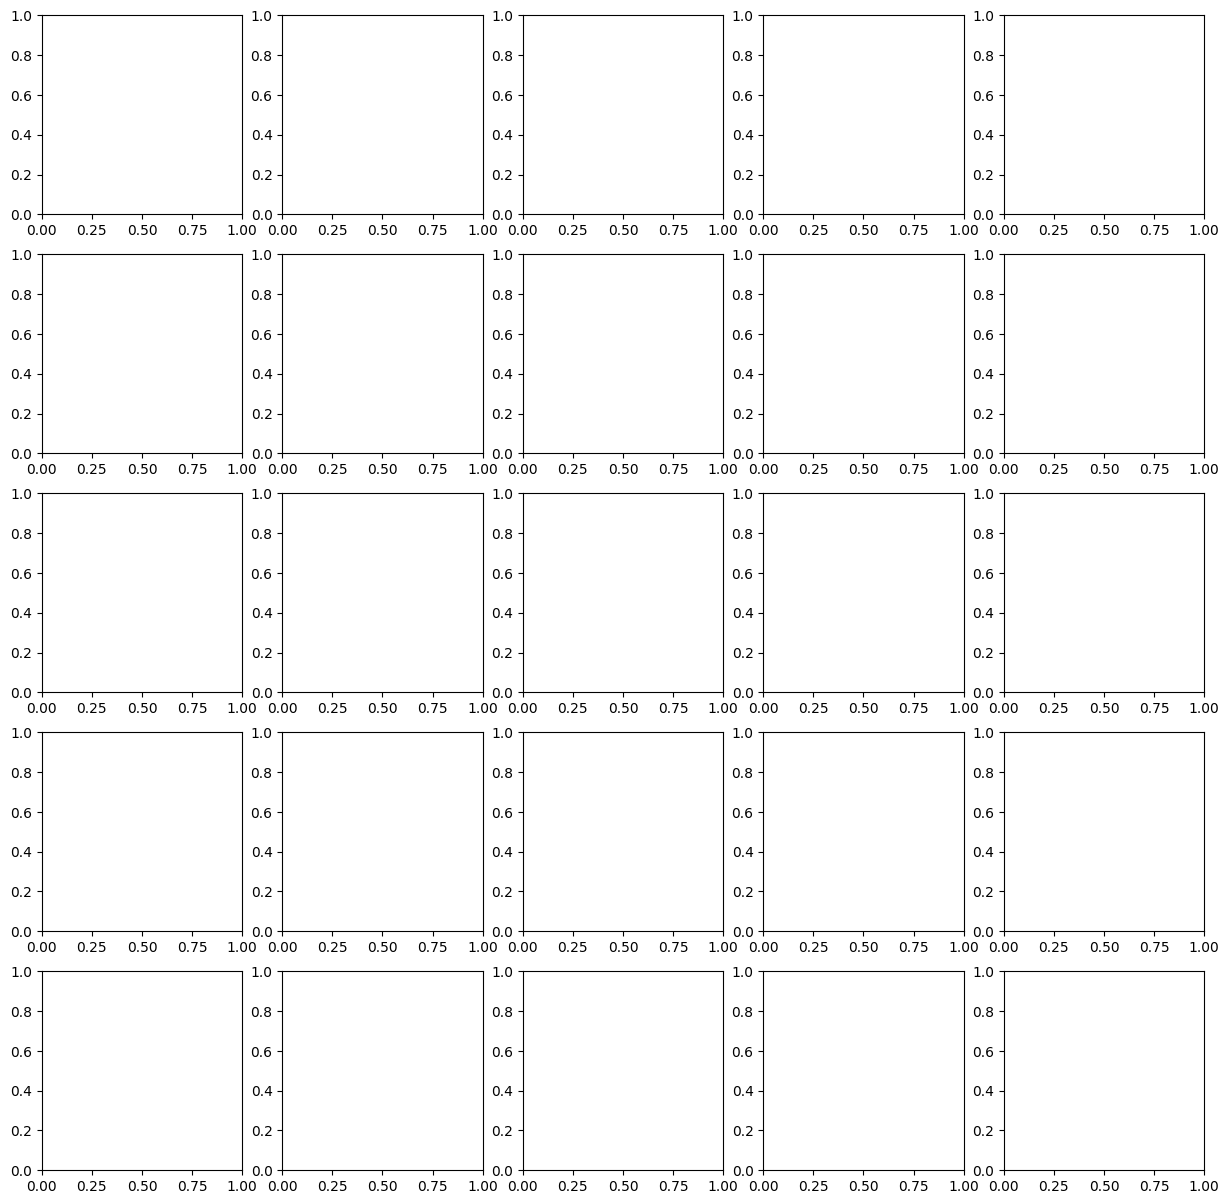

In [10]:
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import psd_array_multitaper
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

# Frequency bands to analyze
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30)
}

# List of valid participant IDs
valid_pids = [el for el in range(1, 32) if el not in [5, 13, 14, 16, 17, 20, 31]]

# Initialize dictionary to store significant channels per participant per band
significant_channels_per_band = {band: {} for band in freq_bands.keys()}

# Function to perform time-frequency analysis using multitaper with per-participant p-value corrections
def time_frequency_analysis_multitaper_per_participant(epochs_condition1, epochs_condition2, freq_bands, participant_id):
    results = []
    channels = epochs_condition1.ch_names  # List of channel names
    sfreq = epochs_condition1.info['sfreq']  # Sampling frequency

    data_c1 = epochs_condition1.get_data()  # Shape: (n_epochs, n_channels, n_times)
    data_c2 = epochs_condition2.get_data()

    for band_name, (fmin, fmax) in freq_bands.items():
        psds_c1 = []
        psds_c2 = []
        # Compute PSD for each epoch in condition 1
        for epoch_data in data_c1:
            psd, freqs = psd_array_multitaper(
                epoch_data, sfreq, fmin=fmin, fmax=fmax, bandwidth=None,
                adaptive=True, low_bias=True, normalization='full', verbose=False)
            psds_c1.append(psd)
        # Compute PSD for each epoch in condition 2
        for epoch_data in data_c2:
            psd, freqs = psd_array_multitaper(
                epoch_data, sfreq, fmin=fmin, fmax=fmax, bandwidth=None,
                adaptive=True, low_bias=True, normalization='full', verbose=False)
            psds_c2.append(psd)
        # Convert to NumPy arrays
        psds_c1 = np.array(psds_c1)  # Shape: (n_epochs, n_channels, n_freqs)
        psds_c2 = np.array(psds_c2)
        # Average over frequency band
        psds_mean_c1 = psds_c1.mean(axis=-1)  # Shape: (n_epochs, n_channels)
        psds_mean_c2 = psds_c2.mean(axis=-1)
        # Perform statistical testing per channel
        p_values = []
        stats = []
        for ch_idx in range(len(channels)):
            data1 = psds_mean_c1[:, ch_idx]
            data2 = psds_mean_c2[:, ch_idx]
            stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
            p_values.append(p_value)
            stats.append(stat)
        # Correct p-values per participant per band
        p_values = np.array(p_values)
        reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
        # Store significant channels
        significant_channels = np.array(channels)[reject]
        significant_channels_per_band[band_name][participant_id] = significant_channels.tolist()
        # Store results
        for ch_idx, ch_name in enumerate(channels):
            results.append({
                'participant': participant_id,
                'band': band_name,
                'channel': ch_name,
                'statistic': stats[ch_idx],
                'p_value': p_values[ch_idx],
                'p_value_corrected': pvals_corrected[ch_idx],
                'significant': reject[ch_idx]
            })
    return pd.DataFrame(results)

# Initialize list to collect results
all_results = []

# Iterate over participants
for participant_id in valid_pids:
    print(f"Processing Participant {participant_id}...")
    try:
        # Load epochs for both conditions (ensure you have this function defined)
        epochs_condition1 = load_participant_epochs(participant_id, 'D')
        epochs_condition2 = load_participant_epochs(participant_id, 'ND')

        # Perform time-frequency analysis and p-value corrections
        participant_results_df = time_frequency_analysis_multitaper_per_participant(
            epochs_condition1, epochs_condition2, freq_bands, participant_id)
        all_results.append(participant_results_df)
    except Exception as e:
        print(f"Error processing Participant {participant_id}: {e}")

# Concatenate all participants' results
final_results_df = pd.concat(all_results, ignore_index=True)

# Save detailed results to CSV
final_results_df.to_csv('time_frequency_analysis_multitaper_corrected_per_participant_results.csv', index=False)

print("Statistical analysis complete. Proceeding to plot topoplots...")



Plotting significant channels for band: theta
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied


C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


0 projection items activated
Not setting metadata
400 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metad

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


0 projection items activated
Not setting metadata
342 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metada

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


365 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


344 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
115 matching events found
No baseline correctio

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


113 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
449 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
249 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events foun

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


433 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correct

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


397 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline corre

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
443 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events fo

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
414 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events foun

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection 

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


324 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correct

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
399 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events fou

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
412 matching events found
No baseline correction applied


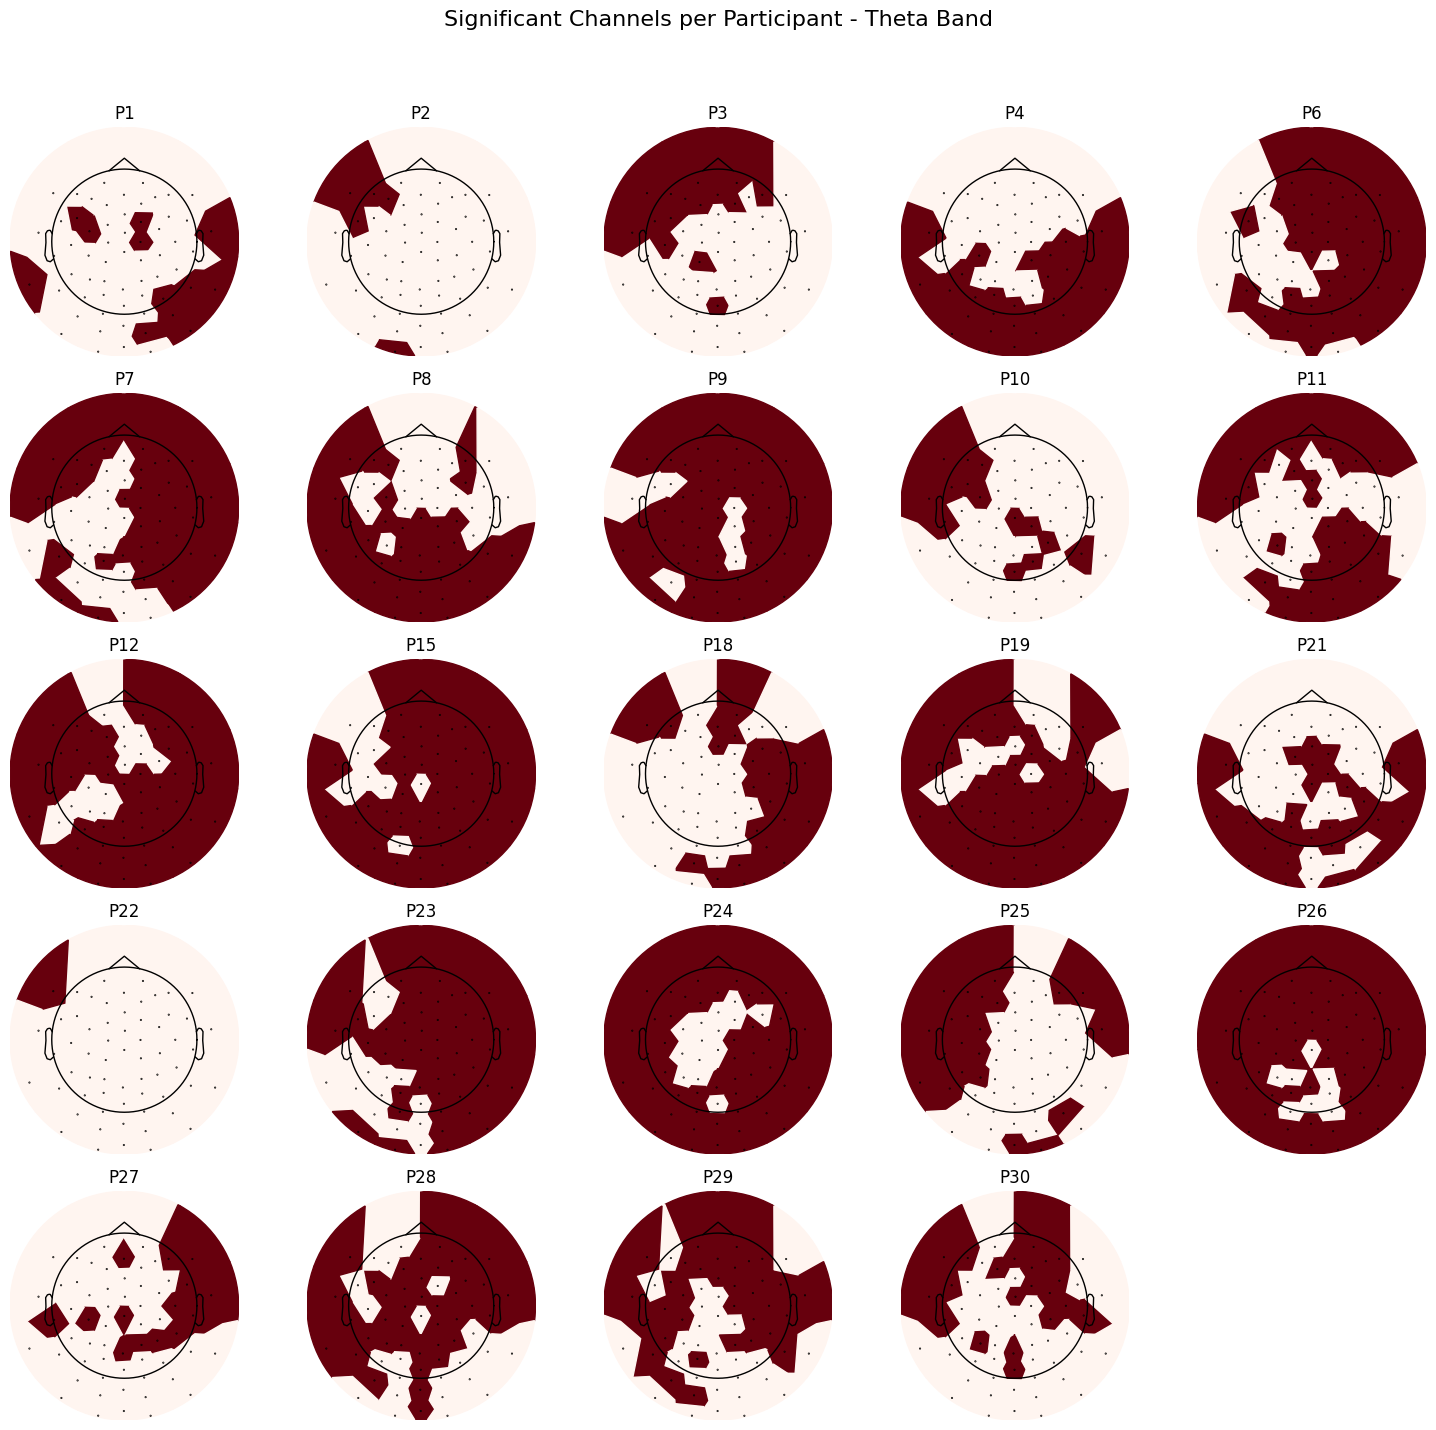

Plotting significant channels for band: alpha
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied


C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
0 projection items activated
Not setting metadata
400 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matri

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


417 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
111 matching events found
No baseline correcti

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


0 projection items activated
Not setting metadata
433 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting met

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
452 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata


C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


132 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D3-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
101 matching e

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
0 projection items activated
Not setting metadata
440 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation ma

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


105 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
414 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


314 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correc

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


399 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correc

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
412 matching events found
No baseline correction applied


C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


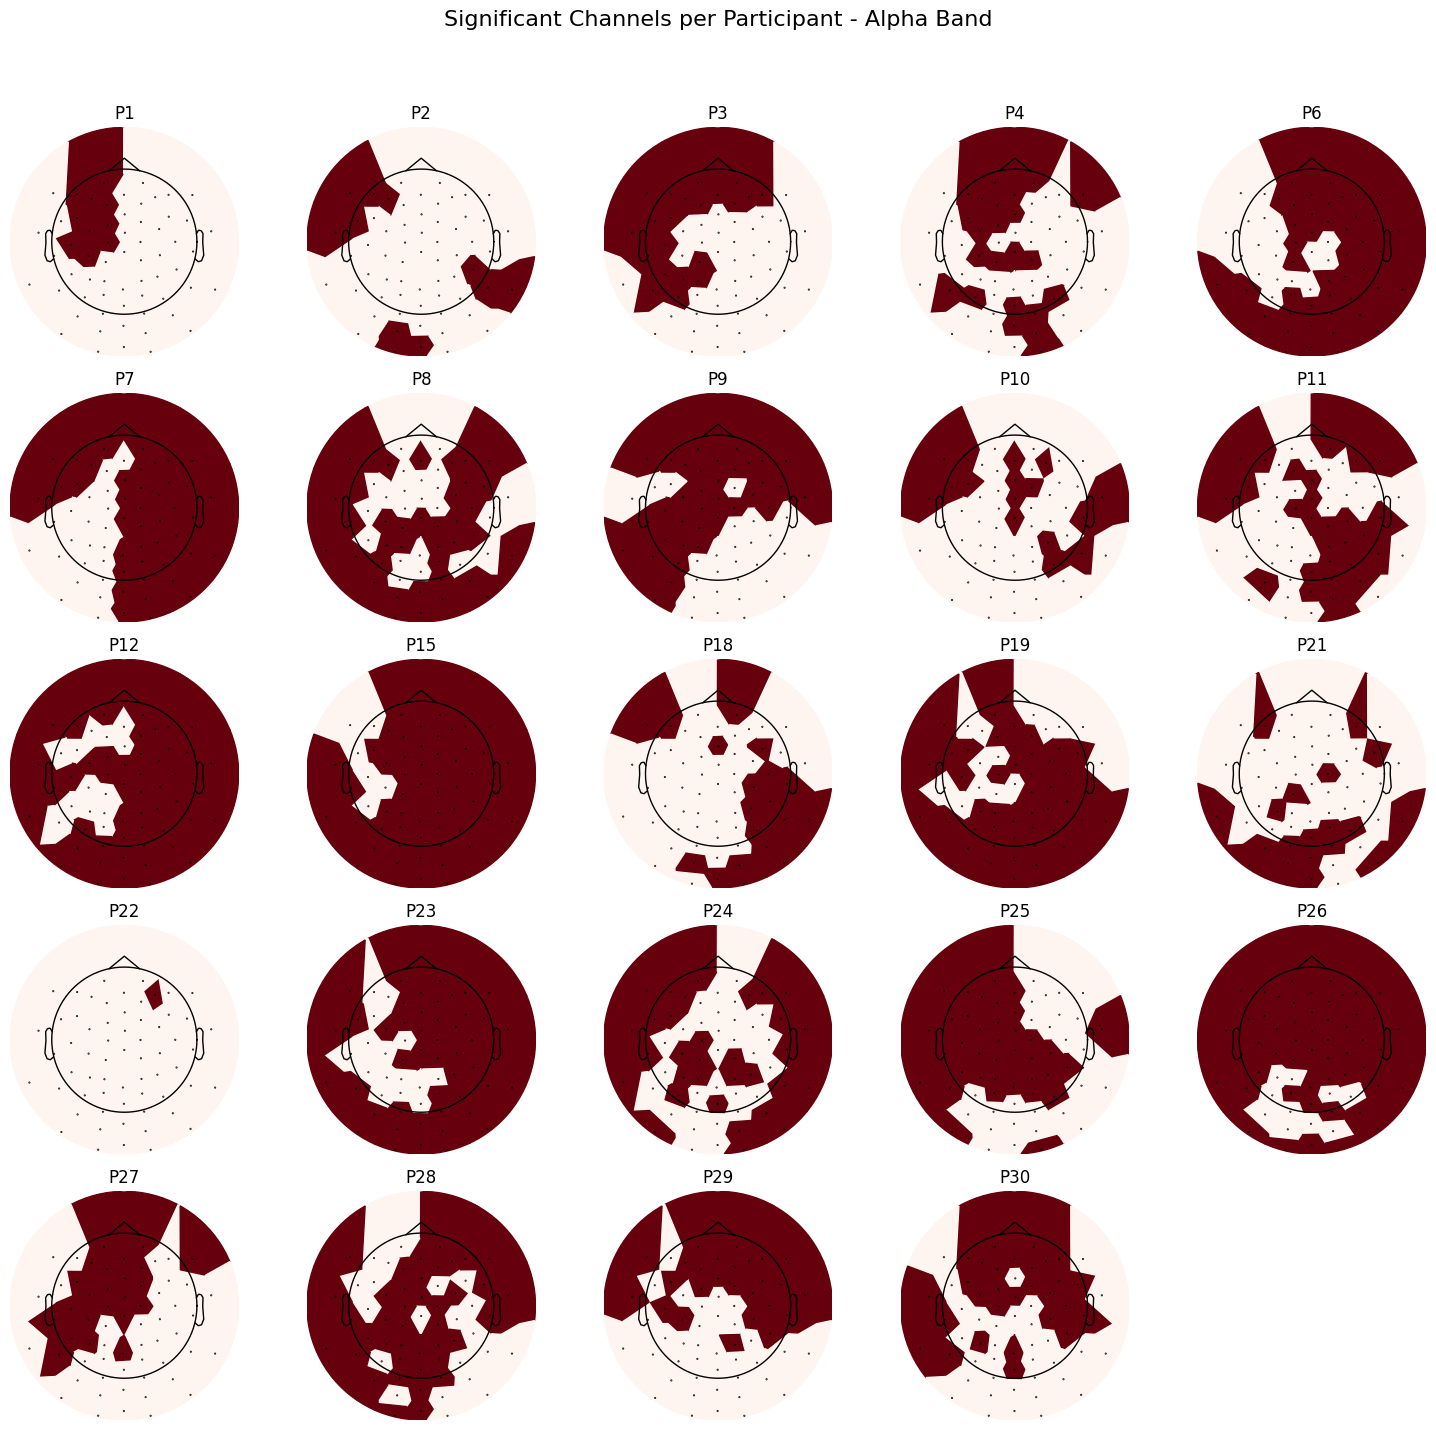

Plotting significant channels for band: beta
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
0

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


400 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correctio

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


365 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
344 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
115 matching events found


C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
449 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
56 matching events foun

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


261 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
137 matching events found
No baseline correc

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


238 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correc

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


114 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
452 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
   

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
443 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events fo

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


105 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
414 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available


C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D3-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
314 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 .

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Reading c:\User

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
348 matching events found
No baseline correction applied
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
109 matching events fou

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


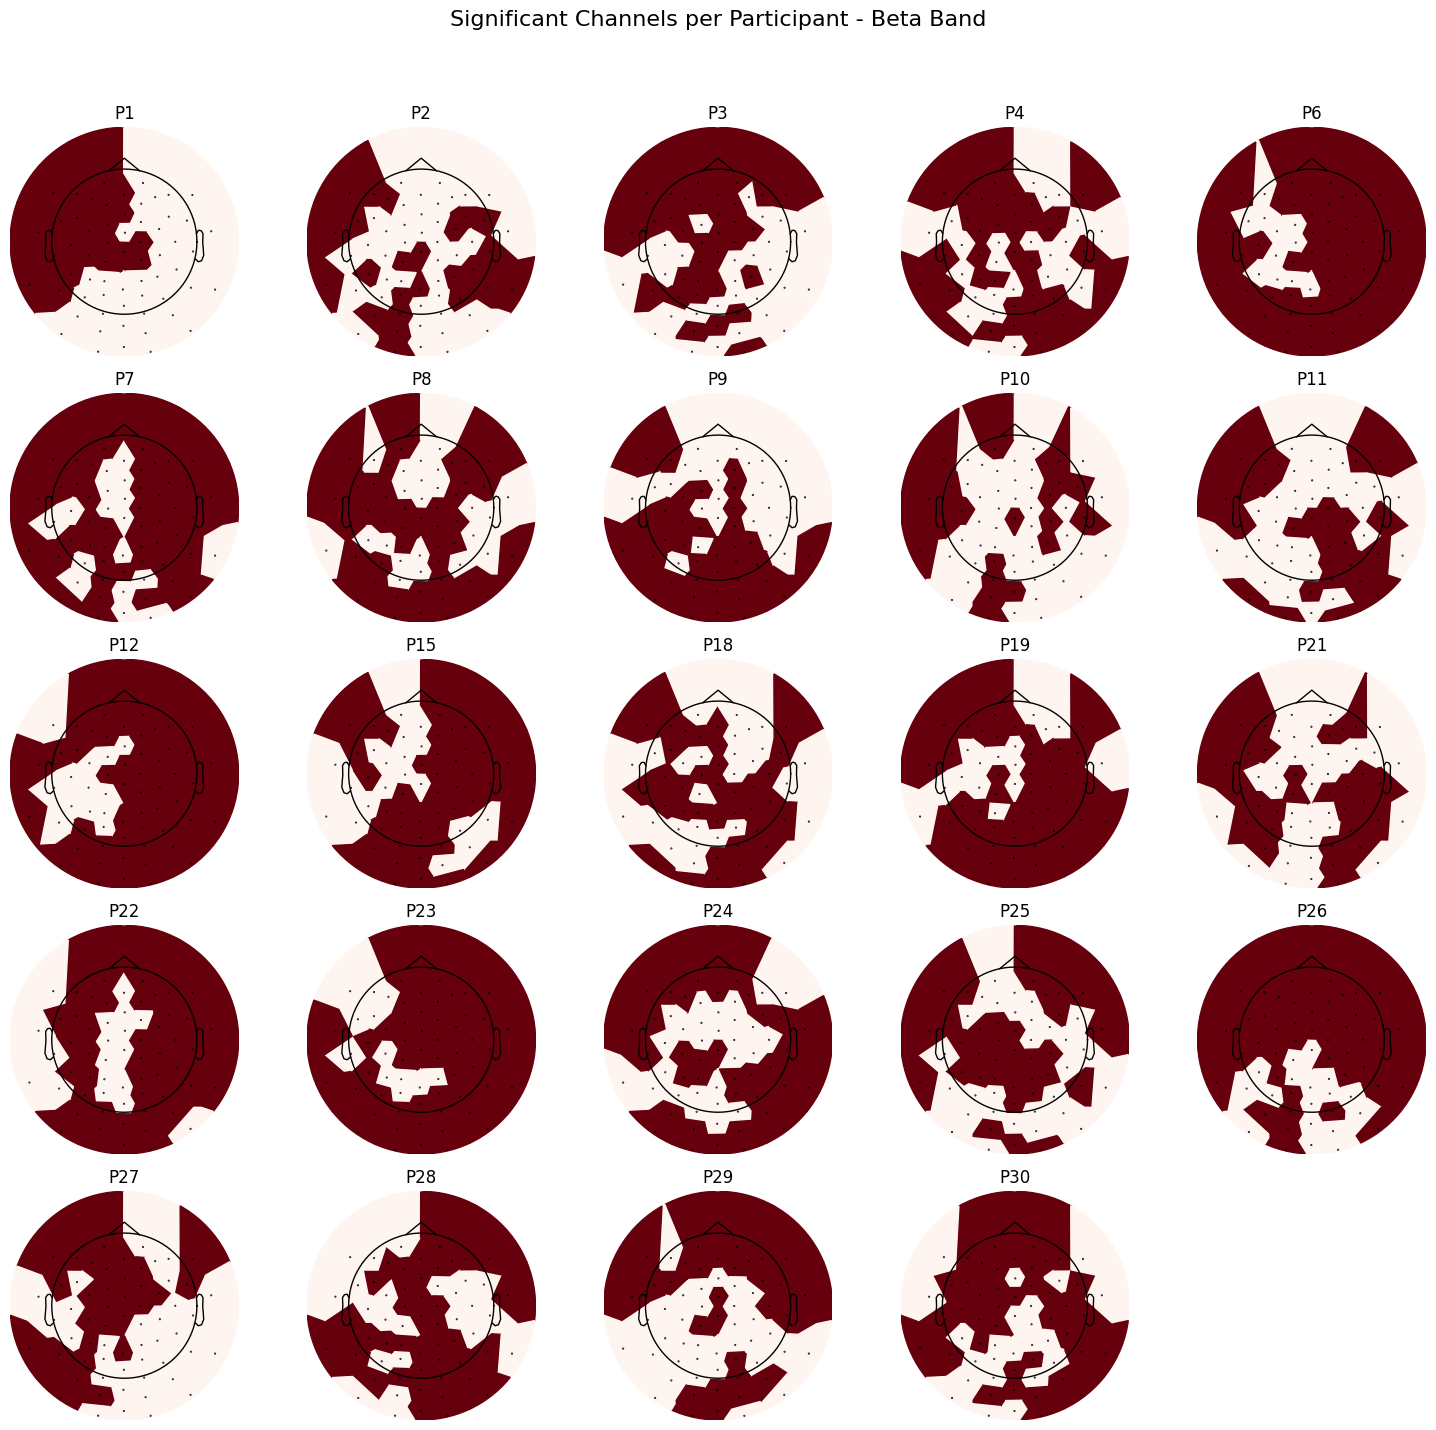

In [11]:
# Plotting significant channels per participant per band
for band_name in freq_bands.keys():
    print(f"Plotting significant channels for band: {band_name}")
    num_participants = len(significant_channels_per_band[band_name])
    if num_participants == 0:
        print(f"No significant channels found for band {band_name}.")
        continue

    # Determine grid size for subplots
    num_cols = 5  # Adjust based on preference
    num_rows = int(np.ceil(num_participants / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
    axes = axes.flatten()

    idx = 0
    for participant_id in sorted(significant_channels_per_band[band_name].keys()):
        sig_channels = significant_channels_per_band[band_name][participant_id]
        ax = axes[idx]
        idx += 1

        # Load participant's epochs to get info and channel names
        epochs_condition1 = load_participant_epochs(participant_id, 'D')  # Or use 'ND', info should be the same
        channel_names = epochs_condition1.ch_names

        # Create data for topomap: 1 for significant, 0 otherwise
        sig_data = np.zeros(len(channel_names))
        for ch in sig_channels:
            if ch in channel_names:
                ch_idx = channel_names.index(ch)
                sig_data[ch_idx] = 1  # Mark significant channels

        # Create an Evoked object (required for plotting)
        info = epochs_condition1.info.copy()
        # Remove bad channels if any
        info['bads'] = []
        evoked = mne.EvokedArray(sig_data[:, np.newaxis], info, tmin=0)

        # Plot topomap
        mne.viz.plot_topomap(
            sig_data,
            evoked.info,
            axes=ax,
            show=False,
            cmap='Reds',
            vlim=(0, 1),
            sensors=True,
            outlines='head',
            contours=0,
            image_interp='nearest',
            extrapolate='local'
        )

        ax.set_title(f'P{participant_id}')
        ax.set_aspect('equal')

    # Remove any unused axes
    for j in range(idx, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Significant Channels per Participant - {band_name.capitalize()} Band', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
